# Machine Learning in the Real World

##                1.Data preparation and cleaning

## Import Python Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.cm
import pathlib
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split

# for map graphical view:
import matplotlib.cm
import matplotlib as mpl
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

# for PCA:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for images comparison:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# model for feature selection:
from sklearn import datasets, linear_model, decomposition
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as sp
import sklearn.feature_selection as fs
from sklearn import kernel_ridge
#import skfeature as skf

# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Imports for kernel ridge:
#from sklearn.model_selection import GridSearchCV


# loading bar
from ipywidgets import FloatProgress
from IPython.display import display

C:\Users\Avi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Avi\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Defining Data Paths And Variables

In [2]:
# Data paths
path_train = 'working_data/train_data.csv'
path_test = 'working_data/test_data.csv'
path_complete_data = 'merged_data_ready/merged_data.csv'
paths = []
#paths.append('raw_data\DB_Data\Jobs.csv')
#paths.append('raw_data\DB_Data\Global_Financial_Development_Data_2.csv')
paths.append('raw_data\DB_Data\Edstast_data.csv')
paths_fixed = []
#paths_fixed.append('raw_data\DB_Data\Job_fixed.csv')
#paths_fixed.append('raw_data\DB_Data\Global_Financial_Development_Data_2_fixed.csv')
paths_fixed.append('raw_data\DB_Data\Edstast_data_fixed.csv')
input_labels = 'raw_data\Labels\Happy_Planet_Index_Data'


# Paths for the graphical map visualization use
countries_codes = 'raw_data/DB_Data/WDI_Country.csv'
shapefile = 'map_files/ne_10m_admin_0_countries'
template_image = 'map_files/imgfile.png'
globe_plots = 'globe_plots/'
uncorrolated_plots = 'uncorrolated_images/'

# Years with labels
rellevant_years_for_labels = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',\
                              '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2012', '2016']
rellevant_years = [year + '.00' for year in rellevant_years_for_labels]

## Obtaining the Data Set

In [21]:
# Merge the data with the labels
def mergeDataWithLabels(working_frame, labels):
    result = pd.merge(working_frame, labels, how='inner', on=['country', 'year'])
    result.to_csv(path_complete_data)

# Cleaning the CSV Files Out From Commas
def cleanCommasFromCSV(path_old, path_new):
    with open(path_old, "r", newline="") as infile, open(path_new, "w", newline="") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(item.replace(",", "") for item in row)

# Obtain The Labeled Data
def getDataFrameForLabelCSV(path, year):
    df = pd.read_csv(path, skiprows=0, usecols=[1, 8])
    df.loc[:, 'year'] = pd.Series(float(rellevant_years[rellevant_years_for_labels.index(year)]), index=df.index)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.drop(df.index[[0]])
    return df

# Take Data From DataSets
def extractDataFromCSV(paths, path_downloaded):
    df = pd.read_csv(paths[0],header=None,skiprows=0, encoding='iso-8859-1')
    df.drop(df.columns[[1,3]], axis=1, inplace=True)
    df.loc[0,0] = 'country'
    df.columns = df.loc[0]
    df = pd.pivot_table(df,index ='country', columns='Indicator Name')
    df = df.stack(level=0)
    df.reset_index(inplace=True)
    df.rename(columns={0: 'year'}, inplace=True)
    df.rename(columns={"Indicator Name": 'series'},inplace=True)
    df.to_csv(path_complete_data, encoding='iso-8859-1')
    df = pd.read_csv(path_complete_data, encoding='iso-8859-1')
    df.drop(df.columns[[0]], axis=1, inplace=True)
    return df

# The Main Data Extract Function
def obtainDataFromLocalDBs():
    f = FloatProgress(min=0, max=100)
    display(f)

    # extract the labels dataframe from the csv files
    lis = []
    for year in rellevant_years_for_labels:
        path = input_labels + '_' + year + '.csv'
        path = pathlib.Path(path)
        df = getDataFrameForLabelCSV(path, year)
        lis.append(df)
    labels_df = pd.concat(lis)
    f.value += 10
    # extract all the data dataframe from the csv files
    for i in range(len(paths)):
        cleanCommasFromCSV(paths[i], paths_fixed[i])
    f.value += 20
    df = extractDataFromCSV(paths_fixed, path_complete_data)
    f.value += 20

    # merge (by inner join) the data with the labels
    mergeDataWithLabels(df, labels_df)
    f.value += 50

# Run to Extract Data (invokes all the other functions above)
obtainDataFromLocalDBs()

## Graphical representation on globus map

### For viewing map graphics, you should install 2 libraries:

#### 1. Install Basemap:
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/
#### 2. Install GeonamesCache:
        · To install this package with conda run, type:
          conda install -c mbonix geonamescache=0.20
          pip install geonamescache
        · download package and install from: https://pypi.python.org/pypi/geonamescache
          look for version 0.20

In [3]:
def plotDataOnMap(data, year = 'mean', feature = "Happy Planet Index", binary=False, descripton=''): 
    if binary:
        num_colors = 2
    else:
        num_colors = 9
    cols = ['country', feature]
    splitted = feature.split()
    title = feature + ' rate per country'
    imgfile = globe_plots + feature + '_'+ year + '.png'
    if descripton == '':
        descripton = '''
        Expected values of the {} rate of countriers. Countries without data are shown in grey.
        Data: World Bank - worldbank.org • Lables: HappyPlanetIndex - happyplanetindex.org'''.format(feature)

    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())
    df = pd.read_csv(countries_codes, skiprows=0, usecols=[0, 1], encoding='iso-8859-1')
    data_map = pd.merge(df, data, how='inner', on=['country'])
    if not binary:
        if year == 'mean':
            data_map = data_map[['Country Code', 'country', feature]]
            data_map = data_map.groupby(['Country Code'], sort=False).mean()
        else:
            data_map = data_map[['Country Code', 'year', 'country', feature]]
            data_map = data_map.loc[data_map['year'] == float(year)]
            data_map = data_map[['Country Code', 'country', feature]]
            data_map = data_map.groupby(['Country Code'], sort=False).first()
    data_map.reset_index(inplace=True)
    values = data_map[feature]
    data_map.set_index('Country Code', inplace=True)
    if not binary:
        cm = plt.get_cmap('Greens')
        scheme = [cm(i / num_colors) for i in range(num_colors)]
    else:
        cm = plt.get_cmap('prism')
        scheme = [cm(i*20 / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    data_map['bin'] = np.digitize(values, bins) - 1
    data_map.sort_values('bin', ascending=False).head(10)
    fig = plt.figure(figsize=(22, 12))

    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    if not binary:
        if year == 'mean':
            fig.suptitle('mean {} rate for all data'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
        else:
            fig.suptitle('{} rate in year {}'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    else:
        fig.suptitle('{} rate'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    
    f = FloatProgress(min=0, max=100)
    display(f)

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in data_map.index:
            color = '#dddddd'
        else:
            ind = data_map.ix[iso3, 'bin'].astype(np.int64)
            color = scheme[ind]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)
        f.value += 75/len(m.units_info)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    if binary:
        grads = np.linspace(0.,10)
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, boundaries=grads, ticks=[0, 10], orientation='horizontal')
        cb.ax.set_xticklabels(['negative', 'positive'])
    else:
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, boundaries=bins, ticks=bins, orientation='horizontal')
        cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])
    f.value += 5

    # Set the map footer.
    plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
    plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    plt.plot()
    f.value += 20

## Images comparison method

### For images map comparison, you should install opencv library
        · To install this package with conda run, type:
        · conda install -c https://conda.binstar.org/menpo opencv
        · download package and install from: http://matplotlib.org/basemap/

In [4]:
def plotUncorrolatedCountries(im1, im2, output):
    img1 = cv2.imread(im1, 1)
    img2 = cv2.imread(im2, 1)
    null_img = cv2.imread(template_image, 1)
    
    img1 = cv2.cvtColor( img1, cv2.COLOR_BGR2GRAY  )
    img2 = cv2.cvtColor( img2, cv2.COLOR_BGR2GRAY  )
    null_img = cv2.cvtColor( null_img, cv2.COLOR_BGR2GRAY  )
    
    height1, width1 = img1.shape
    height2, width2 = img2.shape
    height3, width3 = null_img.shape
    
    min_h = min(height1, height2, height3)
    min_w = min(width1, width2, width3)
    
    img1 = img1[:min_h, :min_w]
    img2 = img2[:min_h, :min_w]
    null_img = null_img[:min_h, :min_w]

    crop_img = cv2.subtract(img1, img2)[65:900, :]

    null_img = null_img[65:900, :]
    thresh = (255-crop_img)
    
    cv2.addWeighted(thresh, 0.5, null_img, 0.5, 0, thresh)
    (threshold, thresh) = cv2.threshold(thresh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    flag = cv2.imwrite(output, thresh)
    plt.axis('off')
    plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic'),plt.show()

## Reading the Working Dataset

In [192]:
overall_data = pd.read_csv(path_complete_data, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
overall_data.head(5)

country    year  \
0  Afghanistan  2012.0   
1  Afghanistan  2016.0   
2      Albania  2006.0   
3      Albania  2009.0   
4      Albania  2012.0   

   Adjusted net enrolment rate lower secondary both sexes (%)  \
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

   Adjusted net enrolment rate lower secondary female (%)  \
0                                                NaN        
1                                                NaN        
2                                                NaN        
3                                                NaN        
4                                                NaN        

   Adjusted net enrolment rate lower secondary gender parity index (GPI)  \
0                                                NaN                       
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

   Adjusted net enrolment rate lower secondary male (%)  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   Adjusted net enrolment rate primary both sexes (%)  \
0                                                NaN    
1                                                NaN    
2                                                NaN    
3                                          89.393333    
4                                          96.137093    

   Adjusted net enrolment rate primary female (%)  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                       88.698219   
4                                       95.353287   

   Adjusted net enrolment rate primary gender parity index (GPI)  \
0                                                NaN               
1                                                NaN               
2                                                NaN               
3                                            0.98508               
4                                            0.98445               

   Adjusted net enrolment rate primary male (%)         ...          \
0                                           NaN         ...           
1                                           NaN         ...           
2                                           NaN         ...           
3                                     90.041763         ...           
4                                     96.859650         ...           

   Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total  \
0                                                NaN                                                                     
1                                                NaN                                                                     
2                                                NaN                                                                     
3                                                NaN                                                                     
4                                                NaN                                                                     

   Youth illiterate population 15-24 years % fema

## Nations tuples count- maybe we will remove some countries before running model

In [193]:
overall_data['country'].value_counts()[:10]

France            20
Finland           20
Sweden            20
Netherlands       20
Germany           20
Mexico            20
United Kingdom    20
Japan             20
Spain             20
Italy             20
Name: country, dtype: int64

## Years tuples histogram- maybe we will remove some years before running model

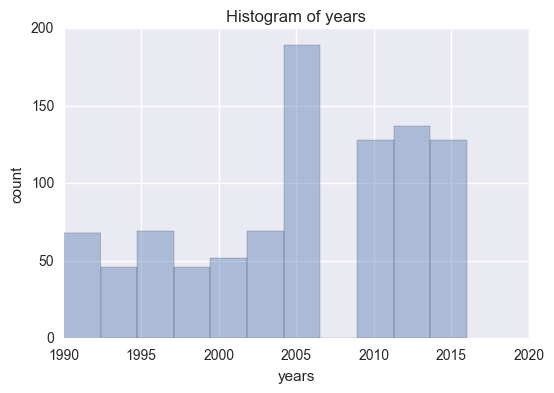

In [194]:
%matplotlib inline
sns.distplot(overall_data['year'], kde = False)
plt.title('Histogram of years')
plt.xlabel('years')
plt.ylabel('count')
plt.show()

### Histogram of Happy Planet Index values

C:\Users\Avi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


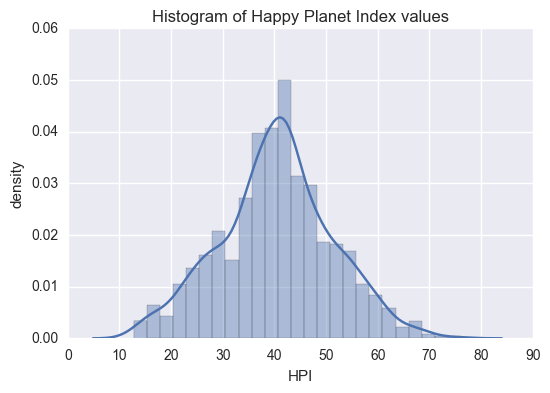

In [195]:
%matplotlib inline
sns.distplot(overall_data['Happy Planet Index'], bins = 25, kde = True)
plt.title('Histogram of Happy Planet Index values')
plt.xlabel('HPI')
plt.ylabel('density')
plt.show()

## Drop  columns with %(nulls)>85%

In [196]:
THRESH = 0.2
overall_data = overall_data.dropna(1, thresh=(overall_data.shape[0] * (1 - THRESH)))
overall_data.head(5)

country    year  GDP PPP (constant 2011 international $)  \
0  Afghanistan  2012.0                             5.646010e+10   
1  Afghanistan  2016.0                                      NaN   
2      Albania  2006.0                             2.237198e+10   
3      Albania  2009.0                             2.632937e+10   
4      Albania  2012.0                             2.840013e+10   

   GDP PPP (current international $)  \
0                       5.750013e+10   
1                                NaN   
2                       2.114751e+10   
3                       2.734912e+10   
4                       3.005072e+10   

   GDP at market prices (constant 2005 US$)  \
0                              1.935220e+10   
1                                       NaN   
2                              9.771760e+09   
3                              1.150029e+10   
4                              1.240477e+10   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                        2.053654e+10                          651.001852   
1                                 NaN                                 NaN   
2                        8.992642e+09                         3265.365622   
3                        1.204421e+10                         3928.340828   
4                        1.231978e+10                         4277.143310   

   GDP per capita (current US$)  \
0                    690.842629   
1                           NaN   
2                   3005.012903   
3                   4114.136545   
4                   4247.839852   

   GDP per capita PPP (constant 2011 international $)  \
0                                        1899.299559    
1                                                NaN    
2                                        7475.899041    
3                                        8993.749193    
4                                        9792.315861    

   GDP per capita PPP (current international $)         ...          \
0                                   1934.285634         ...           
1                                           NaN         ...           
2                                   7066.725645         ...           
3                                   9342.081246         ...           
4                                  10361.433220         ...           

   Population of the official entrance age to secondary general education female (number)  \
0                                           385653.0                                        
1                                           434246.0                                        
2                                            29913.0                                        
3                                            27001.0                                        
4                                            23095.0                                        

   Population of the official entrance age to secondary general education male (number)  \
0                                           406854.0                                      
1                                           460532.0                                      
2                                            31955.0                                      
3                                            28893.0                                      
4                                            24640.0                                      

   Population total  Theoretical duration of pre-primary education (years)  \
0        29726803.0                                                4.0       
1               NaN                                                4.0       
2         2992547.0                                                3.0       
3         2927519.0                                                3.0       
4         2900247.0                                                3.0       

   Theoretical duration of primary education (years)  \
0    

## Find Most Corrolated features

In [197]:
HPI_correlation = overall_data[overall_data.columns[1:-1]].apply\
(lambda x: x.corr(overall_data['Happy Planet Index'], method='spearman'))
HPI_correlation = HPI_correlation.abs().sort_values(ascending=False)
HPI_correlation = pd.DataFrame({'Feature':HPI_correlation.index,\
                                'Correlation to Happy Planet Index':HPI_correlation.values})
HPI_correlation.head(6)

Correlation to Happy Planet Index  \
0                           0.281749   
1                           0.278504   
2                           0.187799   
3                           0.187274   
4                           0.175914   
5                           0.173915   

                                       Feature  
0  Labor force female (% of total labor force)  
1                                         year  
2            GDP PPP (current international $)  
3            GNI PPP (current international $)  
4      GDP PPP (constant 2011 international $)  
5                 Population ages 15-64 female

## Plot Corrolation matrix- taken 2 positive and 2 negative corrolated features

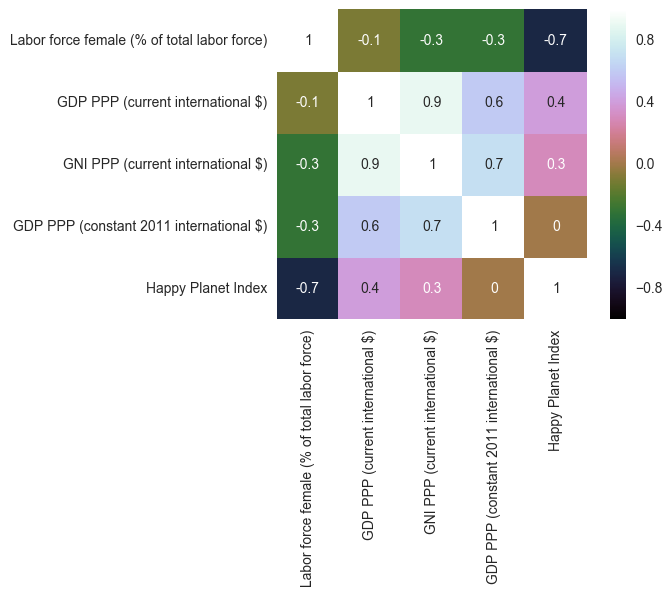

In [198]:
corr_features = HPI_correlation['Feature'].head(5).tolist() + ['Happy Planet Index']
corr_features = [x for x in corr_features if x != 'year']
overall_data_to_plot = overall_data[corr_features]
data_corr_mat= overall_data_to_plot.corr(method='spearman')
c = data_corr_mat.corr(method='spearman')
sns.heatmap(c, vmax=1, square=True, annot=True, cmap='cubehelix')

# Plotting Data on world map

In [199]:
# initialize list containing images' paths for concatination
countries_corrs = []

## Plotting the Happy Planet Index over the globe

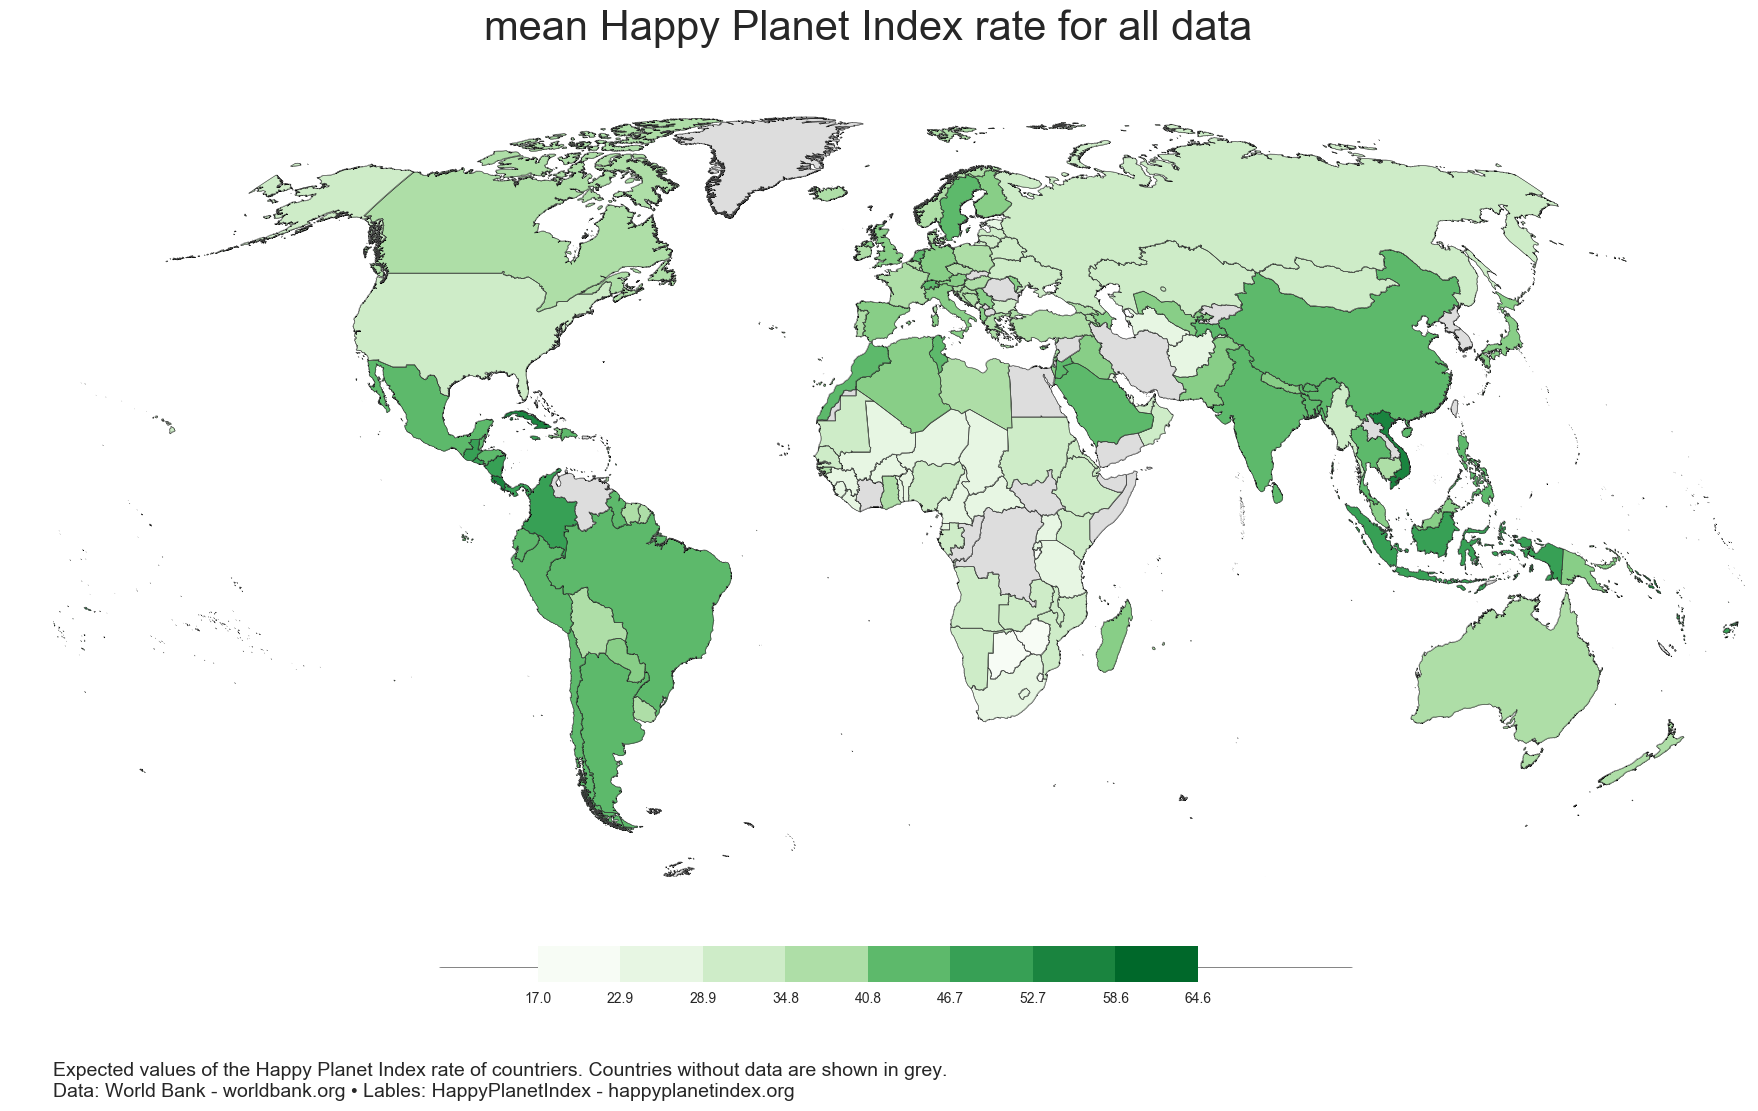

In [200]:
plotDataOnMap(overall_data, feature='Happy Planet Index', year='mean')

## Plotting the $1^{st}$ correlated feature over the globe

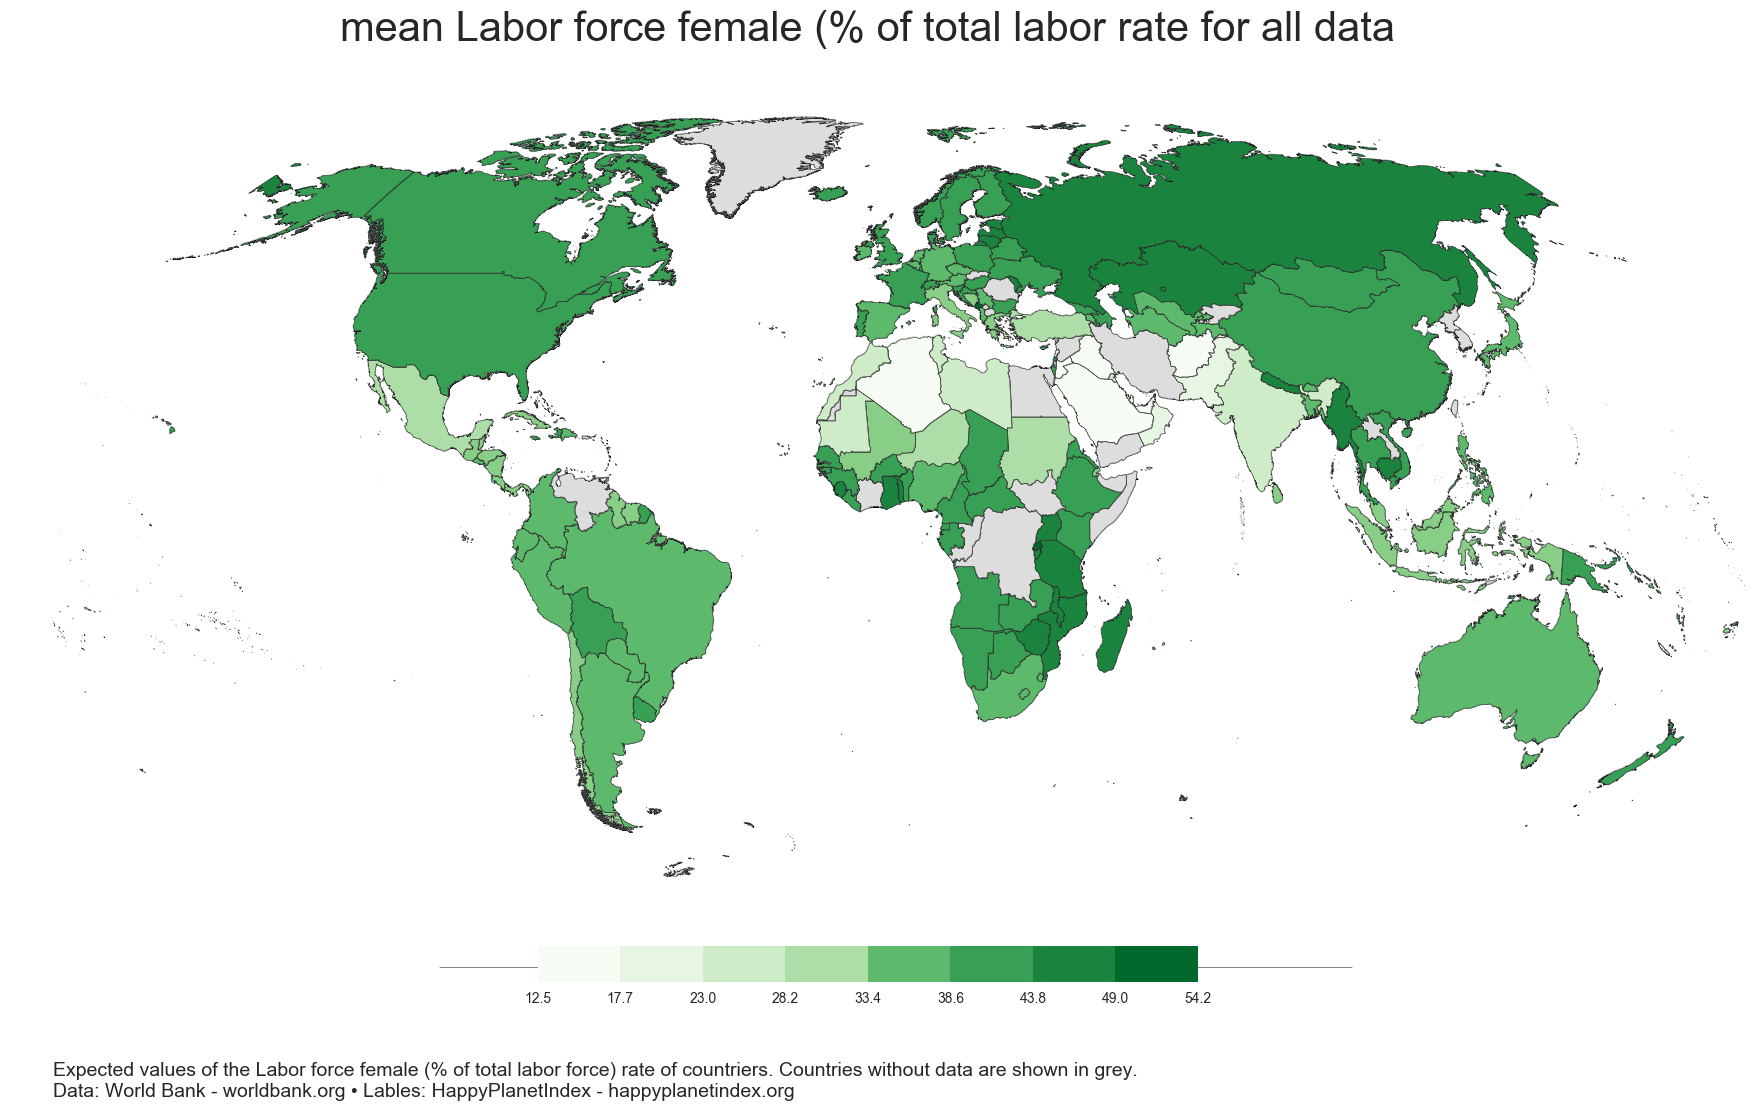

In [17]:
plotDataOnMap(overall_data, feature=corr_features[0], year='mean')

### Which Countries doesn't corrolate in the above feature and target

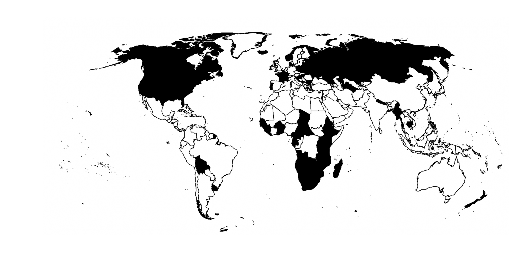

In [201]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + corr_features[0] +'_mean.png'
output_image = uncorrolated_plots + corr_features[0] + '.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the $2^{nd}$ correlated feature over the globe

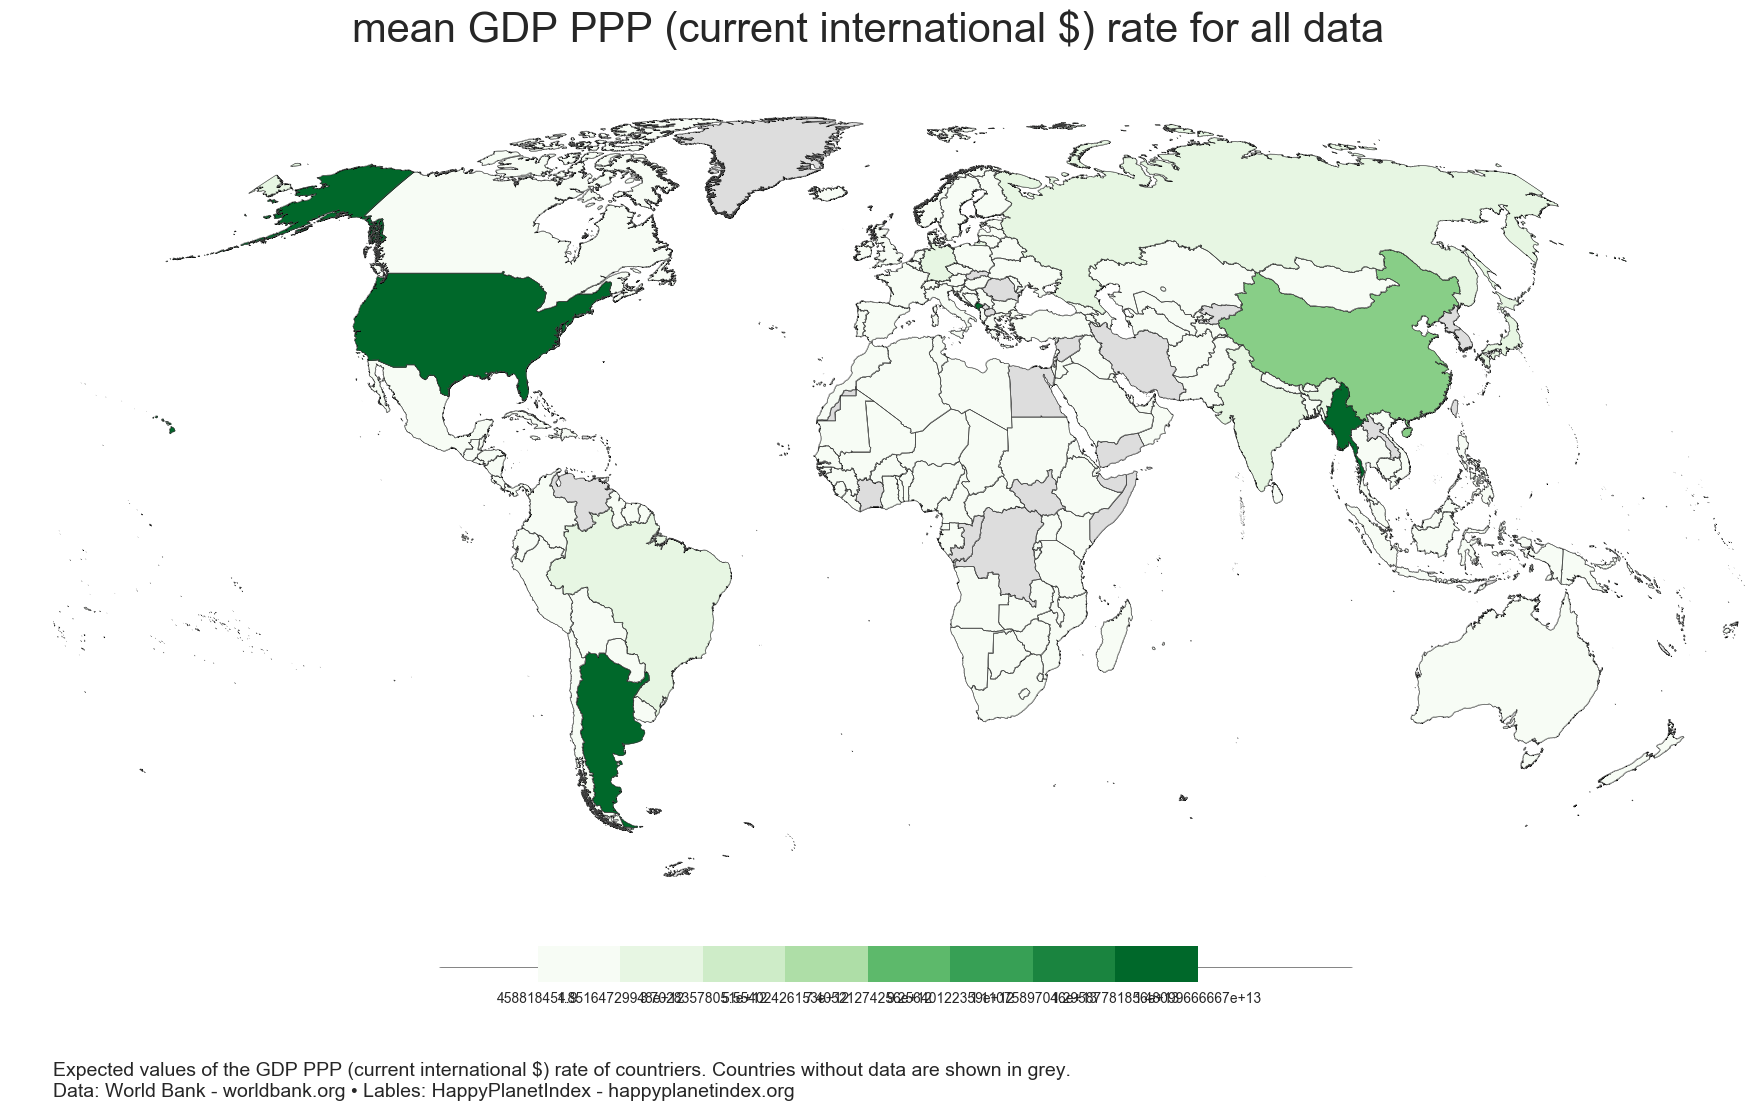

In [22]:
plotDataOnMap(overall_data, feature=corr_features[1], year='mean')

### Which Countries doesn't corrolate in the above feature and target

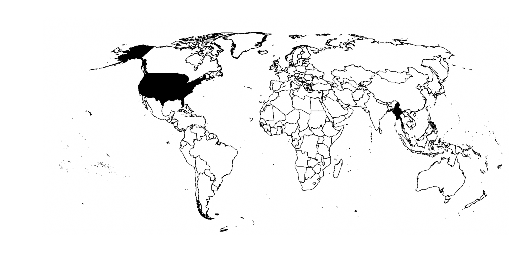

In [202]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + corr_features[1] +'_mean.png'
output_image = uncorrolated_plots + corr_features[1] +'.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the $3^{rd}$ correlated feature over the globe

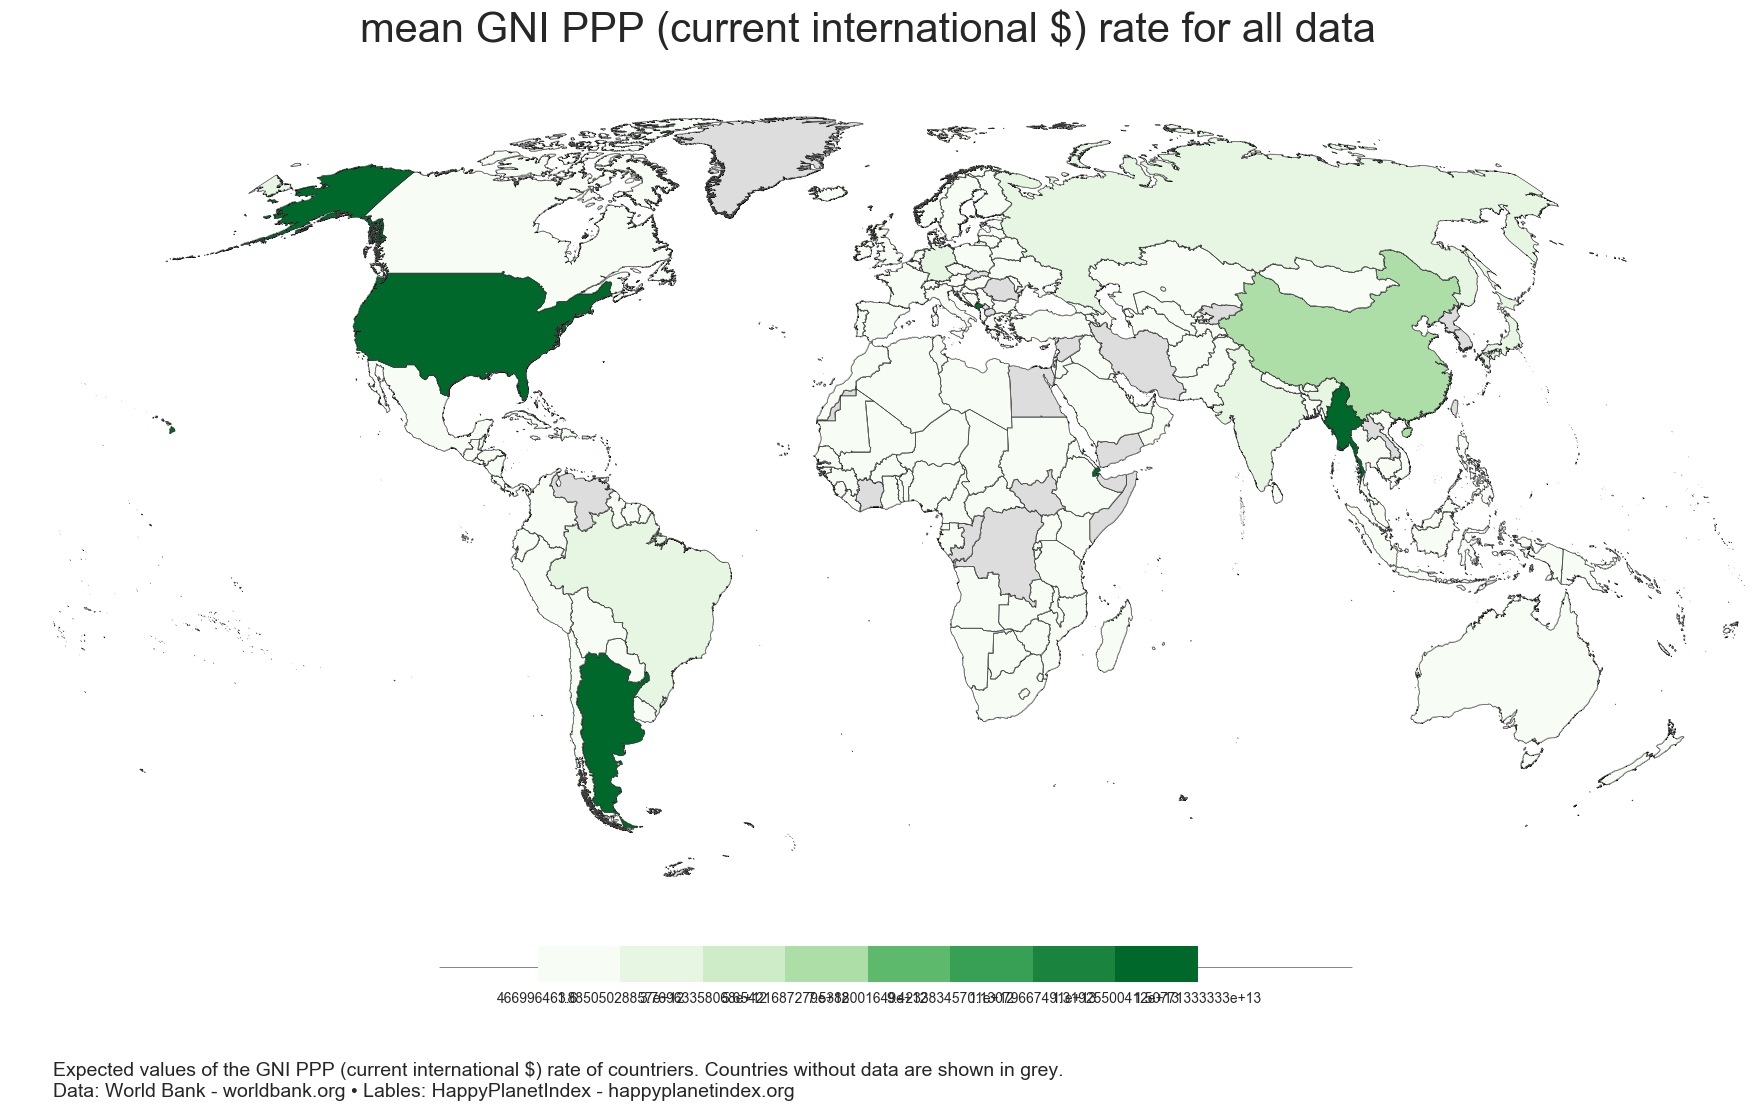

In [24]:
plotDataOnMap(overall_data, feature=corr_features[2], year='mean')

### Which Countries doesn't corrolate in the above feature and target

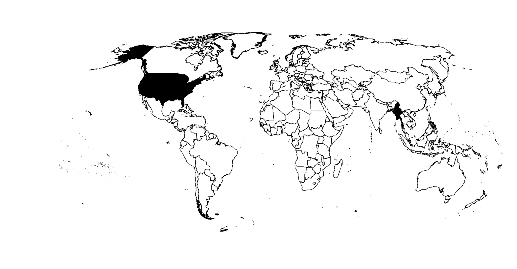

In [203]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + corr_features[2] + '_mean.png'
output_image = uncorrolated_plots + corr_features[2] + '.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the $4^{th}$ correlated feature over the globe

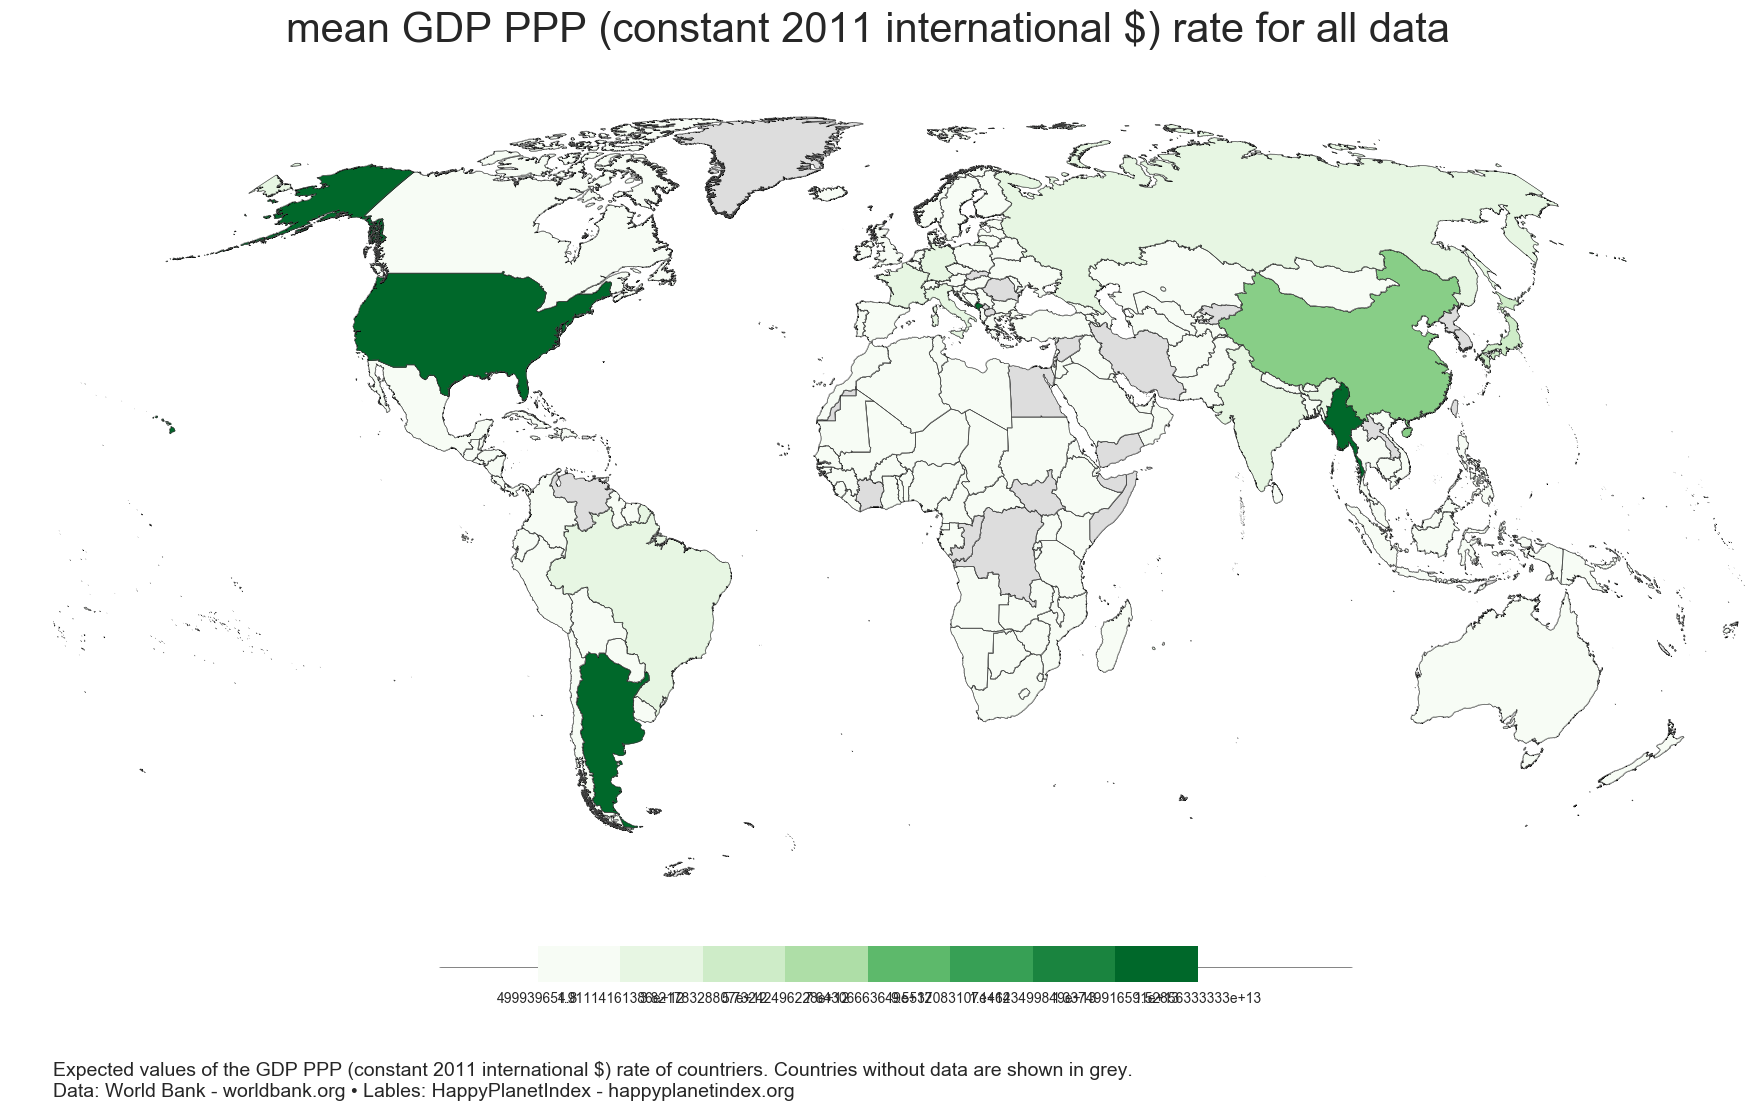

In [26]:
plotDataOnMap(overall_data, feature=corr_features[3], year='mean')

### Which Countries doesn't corrolate in the above feature and target

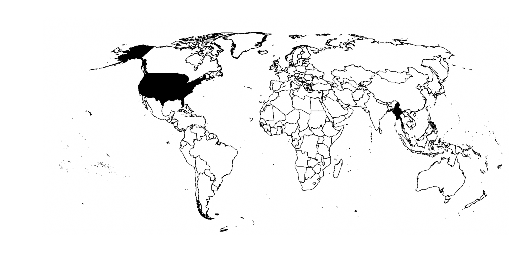

In [204]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + corr_features[3] + '_mean.png'
output_image = uncorrolated_plots + corr_features[3] + '.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

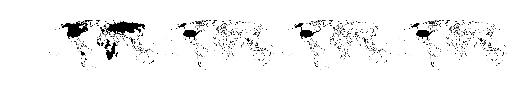

(<matplotlib.image.AxesImage at 0x1fa6dbfaba8>, None)

In [205]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

def concat_n_images(image_path_list):
    """
    Combines N color images from a list of image paths.
    """
    output = None
    for i, img_path in enumerate(image_path_list):
        img = plt.imread(img_path)[:,:]
        if i==0:
            output = img
        else:
            output = concat_images(output, img)
    return output

out = concat_n_images(countries_corrs)
plt.axis('off')
plt.imshow(out, cmap = 'gray', interpolation = 'bicubic'),plt.show()

### Impute nulls with medians

In [206]:
overall_data = overall_data.fillna(overall_data.median())
overall_data.head(5)

country    year  GDP PPP (constant 2011 international $)  \
0  Afghanistan  2012.0                             5.646010e+10   
1  Afghanistan  2016.0                             2.358160e+11   
2      Albania  2006.0                             2.237198e+10   
3      Albania  2009.0                             2.632937e+10   
4      Albania  2012.0                             2.840013e+10   

   GDP PPP (current international $)  \
0                       5.750013e+10   
1                       1.818135e+11   
2                       2.114751e+10   
3                       2.734912e+10   
4                       3.005072e+10   

   GDP at market prices (constant 2005 US$)  \
0                              1.935220e+10   
1                              2.012075e+11   
2                              9.771760e+09   
3                              1.150029e+10   
4                              1.240477e+10   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                        2.053654e+10                          651.001852   
1                        1.414350e+11                        19741.011565   
2                        8.992642e+09                         3265.365622   
3                        1.204421e+10                         3928.340828   
4                        1.231978e+10                         4277.143310   

   GDP per capita (current US$)  \
0                    690.842629   
1                  14099.515080   
2                   3005.012903   
3                   4114.136545   
4                   4247.839852   

   GDP per capita PPP (constant 2011 international $)  \
0                                        1899.299559    
1                                       24743.130720    
2                                        7475.899041    
3                                        8993.749193    
4                                        9792.315861    

   GDP per capita PPP (current international $)         ...          \
0                                   1934.285634         ...           
1                                  18620.785825         ...           
2                                   7066.725645         ...           
3                                   9342.081246         ...           
4                                  10361.433220         ...           

   Population of the official entrance age to secondary general education female (number)  \
0                                           385653.0                                        
1                                           434246.0                                        
2                                            29913.0                                        
3                                            27001.0                                        
4                                            23095.0                                        

   Population of the official entrance age to secondary general education male (number)  \
0                                           406854.0                                      
1                                           460532.0                                      
2                                            31955.0                                      
3                                            28893.0                                      
4                                            24640.0                                      

   Population total  Theoretical duration of pre-primary education (years)  \
0        29726803.0                                                4.0       
1        10513883.0                                                4.0       
2         2992547.0                                                3.0       
3         2927519.0                                                3.0       
4         2900247.0                                                3.0       

   Theoretical duration of primary education (years)  \
0    

## One Hot Encoding Foreach Country

In [207]:
overall_data_countries = overall_data['country']
oh_overall_data = overall_data.drop('country', axis=1)
onehot_overall_col = pd.get_dummies(overall_data['country'], prefix='country')

#check for missing cols in onehot_overall_col
for col in onehot_overall_col.columns:
    if col not in onehot_overall_col.columns:
        onehot_overall_col[col] = 0
        
oh_overall_data = pd.concat([oh_overall_data, onehot_overall_col], axis=1)
overall_data = oh_overall_data
overall_data['country'] = overall_data_countries
overall_data.head(5)

year  GDP PPP (constant 2011 international $)  \
0  2012.0                             5.646010e+10   
1  2016.0                             2.358160e+11   
2  2006.0                             2.237198e+10   
3  2009.0                             2.632937e+10   
4  2012.0                             2.840013e+10   

   GDP PPP (current international $)  \
0                       5.750013e+10   
1                       1.818135e+11   
2                       2.114751e+10   
3                       2.734912e+10   
4                       3.005072e+10   

   GDP at market prices (constant 2005 US$)  \
0                              1.935220e+10   
1                              2.012075e+11   
2                              9.771760e+09   
3                              1.150029e+10   
4                              1.240477e+10   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                        2.053654e+10                          651.001852   
1                        1.414350e+11                        19741.011565   
2                        8.992642e+09                         3265.365622   
3                        1.204421e+10                         3928.340828   
4                        1.231978e+10                         4277.143310   

   GDP per capita (current US$)  \
0                    690.842629   
1                  14099.515080   
2                   3005.012903   
3                   4114.136545   
4                   4247.839852   

   GDP per capita PPP (constant 2011 international $)  \
0                                        1899.299559    
1                                       24743.130720    
2                                        7475.899041    
3                                        8993.749193    
4                                        9792.315861    

   GDP per capita PPP (current international $)  GNI (current US$)  \
0                                   1934.285634       2.157185e+10   
1                                  18620.785825       1.407870e+11   
2                                   7066.725645       9.254605e+09   
3                                   9342.081246       1.185274e+10   
4                                  10361.433220       1.222802e+10   

      ...       country_United Arab Emirates  country_United Kingdom  \
0     ...                                  0                       0   
1     ...                                  0                       0   
2     ...                                  0                       0   
3     ...                                  0                       0   
4     ...                                  0                       0   

   country_United States  country_Uruguay  country_Uzbekistan  \
0                      0                0                   0   
1                      0                0                   0   
2                      0                0                   0   
3                      0                0                   0   
4                      0                0                   0   

   country_Vanuatu  country_Vietnam  country_Zambia  country_Zimbabwe  \
0                0                0               0                 0   
1                0                0               0                 0   
2                0                0               0                 0   
3                0                0               0                 0   
4                0                0               0                 0   

       country  
0  Afghanistan  
1  Afghanistan  
2      Albania  
3      Albania  
4      Albania  

[5 rows x 412 columns]

## Split Data into training set and test set

In [208]:
train_data, test_data = train_test_split(overall_data, test_size = 0.2)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.head(5)

year  GDP PPP (constant 2011 international $)  \
0  2001.0                             6.832920e+11   
1  2009.0                             1.283411e+10   
2  2016.0                             2.358160e+11   
3  2006.0                             6.238350e+11   
4  2012.0                             1.417550e+11   

   GDP PPP (current international $)  \
0                       5.263800e+11   
1                       1.271202e+10   
2                       1.818135e+11   
3                       5.725230e+11   
4                       1.443670e+11   

   GDP at market prices (constant 2005 US$)  \
0                              7.503460e+11   
1                              1.372960e+10   
2                              2.012075e+11   
3                              2.819060e+11   
4                              5.798661e+10   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                        4.265740e+11                        46761.660730   
1                        1.285527e+10                        43107.192180   
2                        1.414350e+11                        19741.011565   
3                        1.454300e+11                         1966.999719   
4                        8.190537e+10                         9228.535527   

   GDP per capita (current US$)  \
0                  26584.121690   
1                  40362.041590   
2                  14099.515080   
3                   1014.734742   
4                  13035.192200   

   GDP per capita PPP (constant 2011 international $)  \
0                                       42582.817150    
1                                       40295.599190    
2                                       24743.130720    
3                                        4352.799802    
4                                       22560.303220    

   GDP per capita PPP (current international $)  GNI (current US$)  \
0                                  32804.066190       4.262170e+11   
1                                  39912.271210       1.047801e+10   
2                                  18620.785825       1.407870e+11   
3                                   3994.771889       1.407870e+11   
4                                  22975.875620       7.997347e+10   

      ...       country_United Arab Emirates  country_United Kingdom  \
0     ...                                  0                       0   
1     ...                                  0                       0   
2     ...                                  0                       0   
3     ...                                  0                       0   
4     ...                                  0                       0   

   country_United States  country_Uruguay  country_Uzbekistan  \
0                      0                0                   0   
1                      0                0                   0   
2                      0                0                   0   
3                      0                0                   0   
4                      0                0                   0   

   country_Vanuatu  country_Vietnam  country_Zambia  country_Zimbabwe  \
0                0                0               0                 0   
1                0                0               0                 0   
2                0                0               0                 0   
3                0                0               0                 0   
4                0                0               0                 0   

       country  
0  Netherlands  
1      Iceland  
2   Kazakhstan  
3      Nigeria  
4        Libya  

[5 rows x 412 columns]

### Partition to factors and class

In [209]:
train_countries = train_data['country']
train_class = train_data['Happy Planet Index']
train_factors = (train_data.drop(['Happy Planet Index', 'country'], axis=1))

test_countries = test_data['country']
test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop(['Happy Planet Index', 'country'], axis=1))
train_factors.head(5)

year  GDP PPP (constant 2011 international $)  \
0  2001.0                             6.832920e+11   
1  2009.0                             1.283411e+10   
2  2016.0                             2.358160e+11   
3  2006.0                             6.238350e+11   
4  2012.0                             1.417550e+11   

   GDP PPP (current international $)  \
0                       5.263800e+11   
1                       1.271202e+10   
2                       1.818135e+11   
3                       5.725230e+11   
4                       1.443670e+11   

   GDP at market prices (constant 2005 US$)  \
0                              7.503460e+11   
1                              1.372960e+10   
2                              2.012075e+11   
3                              2.819060e+11   
4                              5.798661e+10   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                        4.265740e+11                        46761.660730   
1                        1.285527e+10                        43107.192180   
2                        1.414350e+11                        19741.011565   
3                        1.454300e+11                         1966.999719   
4                        8.190537e+10                         9228.535527   

   GDP per capita (current US$)  \
0                  26584.121690   
1                  40362.041590   
2                  14099.515080   
3                   1014.734742   
4                  13035.192200   

   GDP per capita PPP (constant 2011 international $)  \
0                                       42582.817150    
1                                       40295.599190    
2                                       24743.130720    
3                                        4352.799802    
4                                       22560.303220    

   GDP per capita PPP (current international $)  GNI (current US$)  \
0                                  32804.066190       4.262170e+11   
1                                  39912.271210       1.047801e+10   
2                                  18620.785825       1.407870e+11   
3                                   3994.771889       1.407870e+11   
4                                  22975.875620       7.997347e+10   

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                       0                             0   
1        ...                       0                             0   
2        ...                       0                             0   
3        ...                       0                             0   
4        ...                       0                             0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                       0                      0                0   
1                       0                      0                0   
2                       0                      0                0   
3                       0                      0                0   
4                       0                      0                0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                   0                0                0               0   
1                   0                0                0               0   
2                   0                0                0               0   
3                   0                0                0               0   
4                   0                0                0               0   

   country_Zimbabwe  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 410 columns]

### Change all numeric values' datatypes to float

In [210]:
for variable in train_factors.columns:
    train_factors[variable] = train_factors[variable].astype(np.float)
for variable in test_factors.columns:
    test_factors[variable] = test_factors[variable].astype(np.float)

train_factors.dtypes[:10]

year                                                  float64
GDP PPP (constant 2011 international $)               float64
GDP PPP (current international $)                     float64
GDP at market prices (constant 2005 US$)              float64
GDP at market prices (current US$)                    float64
GDP per capita (constant 2005 US$)                    float64
GDP per capita (current US$)                          float64
GDP per capita PPP (constant 2011 international $)    float64
GDP per capita PPP (current international $)          float64
GNI (current US$)                                     float64
dtype: object

## Binning The Years by Decades

In [211]:
#binning the years train
min_year = min(min(train_factors['year']), min(test_factors['year']))

def decade(year):
    return(math.floor((year-min_year) / 10))

for row in range(train_factors.shape[0]):
    val=train_factors.at[row, 'year']
    new_val=decade(val)
    train_factors.set_value(row, 'year', new_val)
    
#binning the years test

for row in range(test_factors.shape[0]):
    val=test_factors.at[row, 'year']
    new_val=decade(val)
    test_factors.set_value(row, 'year', new_val)
train_factors.head(5)

year  GDP PPP (constant 2011 international $)  \
0   1.0                             6.832920e+11   
1   1.0                             1.283411e+10   
2   2.0                             2.358160e+11   
3   1.0                             6.238350e+11   
4   2.0                             1.417550e+11   

   GDP PPP (current international $)  \
0                       5.263800e+11   
1                       1.271202e+10   
2                       1.818135e+11   
3                       5.725230e+11   
4                       1.443670e+11   

   GDP at market prices (constant 2005 US$)  \
0                              7.503460e+11   
1                              1.372960e+10   
2                              2.012075e+11   
3                              2.819060e+11   
4                              5.798661e+10   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                        4.265740e+11                        46761.660730   
1                        1.285527e+10                        43107.192180   
2                        1.414350e+11                        19741.011565   
3                        1.454300e+11                         1966.999719   
4                        8.190537e+10                         9228.535527   

   GDP per capita (current US$)  \
0                  26584.121690   
1                  40362.041590   
2                  14099.515080   
3                   1014.734742   
4                  13035.192200   

   GDP per capita PPP (constant 2011 international $)  \
0                                       42582.817150    
1                                       40295.599190    
2                                       24743.130720    
3                                        4352.799802    
4                                       22560.303220    

   GDP per capita PPP (current international $)  GNI (current US$)  \
0                                  32804.066190       4.262170e+11   
1                                  39912.271210       1.047801e+10   
2                                  18620.785825       1.407870e+11   
3                                   3994.771889       1.407870e+11   
4                                  22975.875620       7.997347e+10   

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0             0.0   
1                 0.0              0.0              0.0             0.0   
2                 0.0              0.0              0.0             0.0   
3                 0.0              0.0              0.0             0.0   
4                 0.0              0.0              0.0             0.0   

   country_Zimbabwe  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 410 columns]

## Centering and Scaling nomeric features, and removing features with: $STD\approx0$ 

In [212]:
train_factors = pd.DataFrame(sp.StandardScaler().fit_transform(train_factors),columns = train_factors.columns)
test_factors = pd.DataFrame(sp.StandardScaler().fit_transform(test_factors),columns = test_factors.columns)
train_factors.head(5)

year  GDP PPP (constant 2011 international $)  \
0 -0.020544                                 0.008613   
1 -0.020544                                -0.472585   
2  1.370816                                -0.312547   
3 -0.020544                                -0.034060   
4  1.370816                                -0.380056   

   GDP PPP (current international $)  \
0                          -0.020042   
1                          -0.419803   
2                          -0.288200   
3                           0.015869   
4                          -0.317343   

   GDP at market prices (constant 2005 US$)  \
0                                  0.123443   
1                                 -0.477557   
2                                 -0.324595   
3                                 -0.258754   
4                                 -0.441448   

   GDP at market prices (current US$)  GDP per capita (constant 2005 US$)  \
0                           -0.043298                            1.183624   
1                           -0.412073                            1.001806   
2                           -0.297461                           -0.160712   
3                           -0.293900                           -1.045008   
4                           -0.350524                           -0.683731   

   GDP per capita (current US$)  \
0                      0.587960   
1                      1.464749   
2                     -0.206527   
3                     -1.039207   
4                     -0.274257   

   GDP per capita PPP (constant 2011 international $)  \
0                                           1.098438    
1                                           0.962525    
2                                           0.038350    
3                                          -1.173305    
4                                          -0.091360    

   GDP per capita PPP (current international $)  GNI (current US$)  \
0                                      0.967815          -0.043466   
1                                      1.472867          -0.408744   
2                                     -0.039937          -0.294252   
3                                     -1.079145          -0.294252   
4                                      0.269501          -0.347684   

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...               -0.090106                     -0.051882   
1        ...               -0.090106                     -0.051882   
2        ...               -0.090106                     -0.051882   
3        ...               -0.090106                     -0.051882   
4        ...               -0.090106                     -0.051882   

   country_United Kingdom  country_United States  country_Uruguay  \
0               -0.157351              -0.063586        -0.073472   
1               -0.157351              -0.063586        -0.073472   
2               -0.157351              -0.063586        -0.073472   
3               -0.157351              -0.063586        -0.073472   
4               -0.157351              -0.063586        -0.073472   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0           -0.073472        -0.051882        -0.082199       -0.073472   
1           -0.073472        -0.051882        -0.082199       -0.073472   
2           -0.073472        -0.051882        -0.082199       -0.073472   
3           -0.073472        -0.051882        -0.082199       -0.073472   
4           -0.073472        -0.051882        -0.082199       -0.073472   

   country_Zimbabwe  
0         -0.063586  
1         -0.063586  
2         -0.063586  
3         -0.063586  
4         -0.063586  

[5 rows x 410 columns]

## Apply PCA for data visualizaion

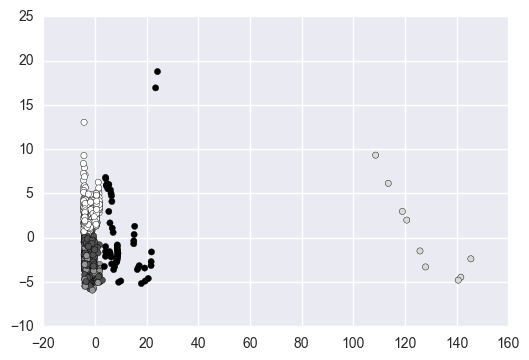

In [213]:
# Import the kmeans clustering model.
def twoDimPCAandClustering(train_factors):
    # Initialize the model with 2 parameters -- number of clusters and random state.
    kmeans_model = KMeans(n_clusters=5, random_state=1)
    # Get only the numeric columns from games.
    # Fit the model using the good columns.
    kmeans_model.fit(train_factors)
    # Get the cluster assignments.
    labels = kmeans_model.labels_
    #Import the PCA model.

    # Create a PCA model.
    pca_2 = PCA(2)
    # Fit the PCA model on the numeric columns from earlier.
    plot_columns = pca_2.fit_transform(train_factors)
    # Make a scatter plot of each game, shaded according to cluster assignment.
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
    # Show the plot.
    plt.show()
    return plot_columns, labels
plot_columns, labels = twoDimPCAandClustering(train_factors)

## Feature selection with E.Net model

In [214]:
# run elastic model for feature selection 
enet = ElasticNetCV(max_iter=30000, cv=20, n_jobs=-1)
enet.fit(train_factors, train_class)

sfm = fs.SelectFromModel(enet, prefit=True)
chosen_features_and_coefs = [(train_factors.columns[i],enet.coef_[i]) for i in sfm.get_support(True)]

def comp(tuple):
    return abs(tuple[1])

chosen_features_and_coefs.sort(key=comp, reverse=True)
headers = [['correlated feature', 'linear correlation rate to target']]
data = headers + [[x[0], x[1]]\
                  for x in chosen_features_and_coefs]
headers = data.pop(0) # gives the headers as list and leaves data
table = pd.DataFrame(data, columns=headers)
print("Enet Strong factors are: ")
table.head(10)

Enet Strong factors are: 


C:\Users\Avi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


correlated feature  \
0  GDP per capita PPP (constant 2011 internationa...   
1                  Population ages 0-14 (% of total)   
2       GDP per capita PPP (current international $)   
3                 Population ages 15-64 (% of total)   
4            GDP PPP (constant 2011 international $)   
5                                               year   
6                    Internet users (per 100 people)   
7                       GDP per capita (current US$)   
8        Labor force female (% of total labor force)   
9          GNI per capita Atlas method (current US$)   

   linear correlation rate to target  
0                         -10.436941  
1                           6.753522  
2                           4.635556  
3                           4.310555  
4                          -3.963612  
5                          -3.809181  
6                           3.359397  
7                           2.385695  
8                          -2.269375  
9                          -2.205973

## Compute statistics on training set for Enet prediction

In [217]:
train_r_squared = enet.score(train_factors, train_class)
train_predictions = enet.predict(train_factors)

# Compute the error.test_mse = mean_squared_error(y_test, rf.predict(test_factors))
train_rmse = np.sqrt(mean_squared_error(train_class, train_predictions))
                    
print("train R^2, %.4f, train RMSE, %.4f" % (train_r_squared, train_rmse))

train R^2, 0.8515, train RMSE, 4.1426


## Countries corrolated to target plot

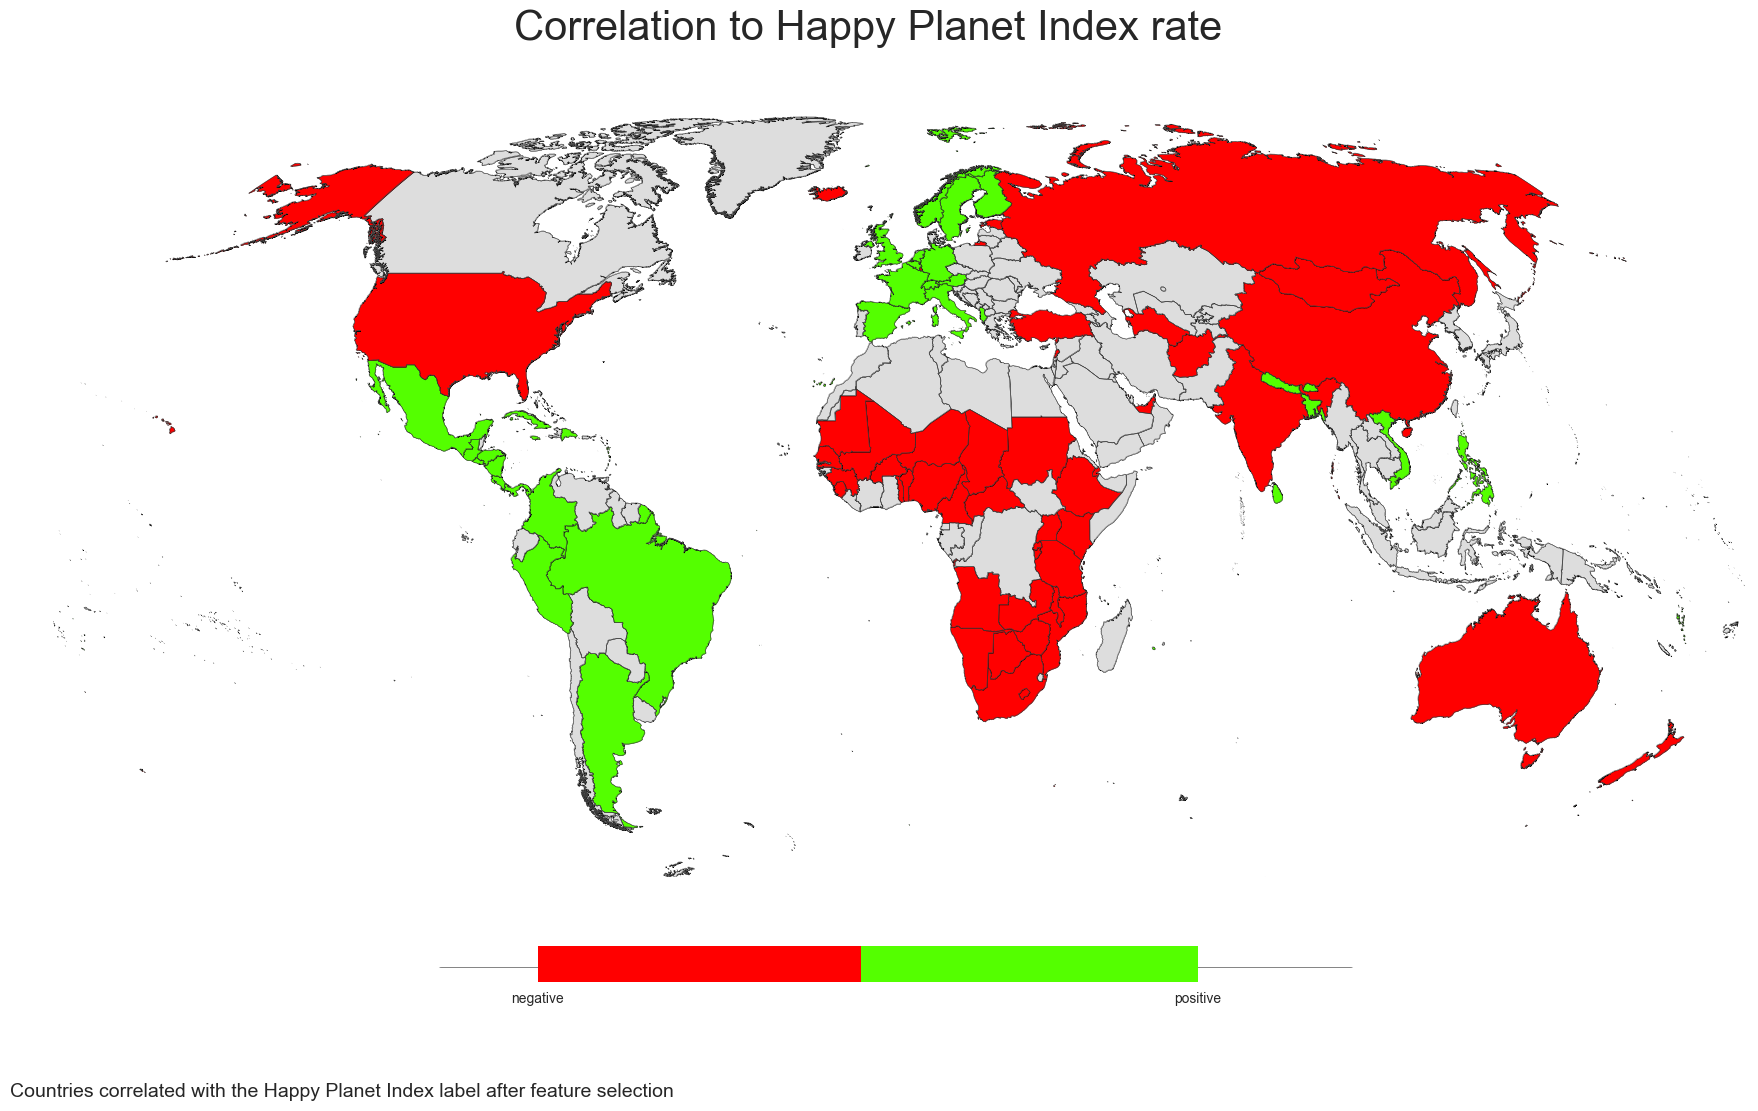

In [218]:
headers = [['country', 'Correlation to Happy Planet Index']]
data = headers + [[x[0].split('country_')[1], np.sign(x[1])]\
                  for x in chosen_features_and_coefs if x[0].startswith('country_')]
headers = data.pop(0) # gives the headers as list and leaves data
df = pd.DataFrame(data, columns=headers)
plotDataOnMap(df, year='mean', feature="Correlation to Happy Planet Index", binary=True,\
              descripton='Countries correlated with the Happy Planet Index label after feature selection')

### Take remained features

In [219]:
chosen_features = [x[0] for x in chosen_features_and_coefs]
train_factors = train_factors[chosen_features]
test_factors = test_factors[chosen_features]
train_factors.head(5)

GDP per capita PPP (constant 2011 international $)  \
0                                           1.098438    
1                                           0.962525    
2                                           0.038350    
3                                          -1.173305    
4                                          -0.091360    

   Population ages 0-14 (% of total)  \
0                          -0.599754   
1                          -0.308483   
2                          -0.432742   
3                           2.135024   
4                           0.579041   

   GDP per capita PPP (current international $)  \
0                                      0.967815   
1                                      1.472867   
2                                     -0.039937   
3                                     -1.079145   
4                                      0.269501   

   Population ages 15-64 (% of total)  \
0                            0.577336   
1                            0.382872   
2                            0.281201   
3                           -2.172217   
4                            0.279312   

   GDP PPP (constant 2011 international $)      year  \
0                                 0.008613 -0.020544   
1                                -0.472585 -0.020544   
2                                -0.312547  1.370816   
3                                -0.034060 -0.020544   
4                                -0.380056  1.370816   

   Internet users (per 100 people)  GDP per capita (current US$)  \
0                         1.066305                      0.587960   
1                         2.858178                      1.464749   
2                        -0.351856                     -0.206527   
3                        -0.733827                     -1.039207   
4                        -0.351856                     -0.274257   

   Labor force female (% of total labor force)  \
0                                     0.210446   
1                                     0.724954   
2                                     0.273693   
3                                     0.121325   
4                                    -2.063823   

   GNI per capita Atlas method (current US$)       ...        \
0                                   0.683521       ...         
1                                   1.690117       ...         
2                                  -0.212235       ...         
3                                  -1.080533       ...         
4                                  -0.409469       ...         

   Theoretical duration of secondary education (years)  \
0                                          -0.518286     
1                                           0.581779     
2                                           1.681845     
3                                          -0.518286     
4                                          -0.518286     

   Unemployment female (% of female labor force)  country_Nepal  \
0                                      -1.088067      -0.073472   
1                                      -0.569753      -0.073472   
2                                      -0.252076      -0.073472   
3                                      -0.252076      -0.073472   
4                                       3.142044      -0.073472   

   country_Belgium  country_Estonia  country_Albania  Population age 4 female  \
0        -0.133265        -0.036662        -0.063586                -0.209500   
1        -0.133265        -0.036662        -0.063586                -0.295823   
2        -0.133265        -0.036662        -0.063586                -0.212064   
3        -0.133265        -0.036662        -0.063586                 1.726076   
4        -0.133265        -0.036662        -0.063586                -0.234498   

   country_Luxembourg  country_Mongolia  country_Mexico  
0           -0.133265         -0.063586       -0.148148  
1           -0.133265         -0.063586       -0.148148  
2           -0.13326

### Apply PCA after feature selection

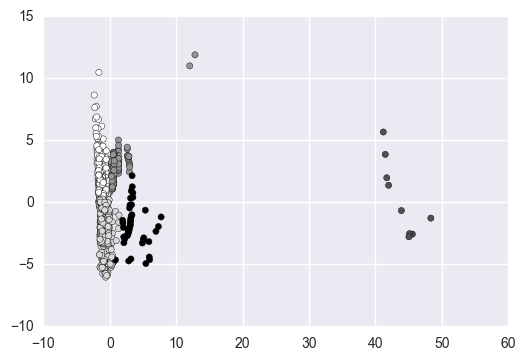

In [220]:
plot_columns, labels = twoDimPCAandClustering(train_factors)

## Features extraction

In [221]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
transf_test = poly.fit_transform(test_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))
test_factors_after_extracion = (pd.DataFrame(transf_test, columns = target_feature_names))
train_factors_after_extracion.head(5)

GDP per capita PPP (constant 2011 international $)^1  \
0                                           1.098438      
1                                           0.962525      
2                                           0.038350      
3                                          -1.173305      
4                                          -0.091360      

   Population ages 0-14 (% of total)^1  \
0                            -0.599754   
1                            -0.308483   
2                            -0.432742   
3                             2.135024   
4                             0.579041   

   GDP per capita PPP (current international $)^1  \
0                                        0.967815   
1                                        1.472867   
2                                       -0.039937   
3                                       -1.079145   
4                                        0.269501   

   Population ages 15-64 (% of total)^1  \
0                              0.577336   
1                              0.382872   
2                              0.281201   
3                             -2.172217   
4                              0.279312   

   GDP PPP (constant 2011 international $)^1    year^1  \
0                                   0.008613 -0.020544   
1                                  -0.472585 -0.020544   
2                                  -0.312547  1.370816   
3                                  -0.034060 -0.020544   
4                                  -0.380056  1.370816   

   Internet users (per 100 people)^1  GDP per capita (current US$)^1  \
0                           1.066305                        0.587960   
1                           2.858178                        1.464749   
2                          -0.351856                       -0.206527   
3                          -0.733827                       -1.039207   
4                          -0.351856                       -0.274257   

   Labor force female (% of total labor force)^1  \
0                                       0.210446   
1                                       0.724954   
2                                       0.273693   
3                                       0.121325   
4                                      -2.063823   

   GNI per capita Atlas method (current US$)^1        ...         \
0                                     0.683521        ...          
1                                     1.690117        ...          
2                                    -0.212235        ...          
3                                    -1.080533        ...          
4                                    -0.409469        ...          

   Population age 4 female^2  Population age 4 female^1xcountry_Luxembourg^1  \
0                   0.043890                                        0.027919   
1                   0.087511                                        0.039423   
2                   0.044971                                        0.028261   
3                   2.979337                                       -0.230025   
4                   0.054989                                        0.031250   

   Population age 4 female^1xcountry_Mongolia^1  \
0                                      0.013321   
1                                      0.018810   
2                                      0.013484   
3                                     -0.109754   
4                                      0.014911   

   Population age 4 female^1xcountry_Mexico^1  country_Luxembourg^2  \
0                                    0.031037               0.01776   
1                                    0.043826               0.01776   
2                                    0.031417               0.01776   
3                                   -0.255715               0.01776   
4                                    0.034740               0.01776   

   country_Luxembourg^1xcountry_Mongolia^1  \
0                                 0.008474   
1     

## Corrolations between target and extracted features

In [222]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))

max_corr_before = HPI_correlation['Correlation to Happy Planet Index'].iloc[0]
HPI_correlation_feature_extraction = train_factors_after_extracion[train_factors_after_extracion.columns[:]].apply\
(lambda x: x.corr(train_data['Happy Planet Index'], method='spearman'))
HPI_correlation_feature_extraction = HPI_correlation_feature_extraction.abs().sort_values(ascending=False)
HPI_correlation_feature_extraction = pd.DataFrame({'Feature':HPI_correlation_feature_extraction.index,\
                                'Correlation to Happy Planet Index':HPI_correlation_feature_extraction.values})
HPI_correlation_feature_extraction = HPI_correlation_feature_extraction.loc\
[(HPI_correlation_feature_extraction["Correlation to Happy Planet Index"] > max_corr_before) \
 & ((HPI_correlation_feature_extraction["Feature"].str.count("\^") == 2) | ((HPI_correlation_feature_extraction["Feature"].str.count("\^2") == 1)))]
print('There are', HPI_correlation_feature_extraction.shape[0],\
      'new features that are more corrolative to target then old features and many other new very correlative features')
HPI_correlation_feature_extraction.head(5)

There are 6 new features that are more corrolative to target then old features and many other new very correlative features


Correlation to Happy Planet Index  \
0                           0.367983   
1                           0.367268   
2                           0.355199   
3                           0.321363   
4                           0.306730   

                                             Feature  
0  GDP per capita (current US$)^1xLabor force fem...  
1  Labor force female (% of total labor force)^1x...  
2  Labor force female (% of total labor force)^1x...  
3  GDP per capita PPP (current international $)^1...  
4  GDP per capita PPP (constant 2011 internationa...

# Kernel Ridge model

In [223]:
from sklearn.kernel_ridge import KernelRidge

#tuned_parameters = {'alpha': [1, 0.1, 0.15, 0.155, 0.1555], 'degree': [1, 2, 3, 4, 5], 'gamma': [1,0.1,0.01,0.001, 0.0001, None], 'kernel': ['polynomial']}
#model = KernelRidge(alpha=0.007, degree=2, kernel='polynomial',gamma=0.0022)
#model = KernelRidge(alpha=0.00007, degree=2, kernel='polynomial',gamma=0.000022)

#param_grid = {'alpha': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12],\
#              'gamma': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

alp = [x for x in frange(1e-4, 1e-2, 3e-4)]
param_grid = {'alpha': alp,\
              'gamma': alp}

#cross_v = train_factors.shape[0]
#model = GridSearchCV(KernelRidge(degree=2, kernel='polynomial', alpha=0.0004, gamma=0.0004), cv=cross_v, param_grid=param_grid, n_jobs=-1)
model = KernelRidge(alpha=0.0004, degree=2, kernel='polynomial',gamma=0.0004)


model.fit(train_factors, train_class)
test_predictions = model.predict(test_factors)
train_predictions = model.predict(train_factors)

## Compute statistics on training set for Enet prediction

In [224]:
# Compute the RMSE
train_mse = np.sqrt(mean_squared_error(train_class, train_predictions))
test_mse = np.sqrt(mean_squared_error(test_class, test_predictions))

# Compute R^2 values
train_r_squared = model.score(train_factors, train_class)
test_r_squared = model.score(test_factors, test_class)


print("train RMSE, %.4f, test RMSE: %.4f" % (train_mse, test_mse))
print("train R^2, %.4f, test R^2: %.4f" % (train_r_squared, test_r_squared))

train RMSE, 3.8896, test RMSE: 7.2860
train R^2, 0.8691, test R^2: 0.5797


C:\Users\Avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


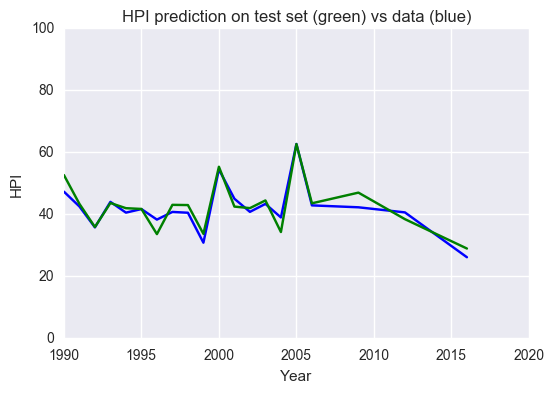

In [231]:
data_to_plot = test_data[['year','country']]
data_to_plot['prediction'] = pd.Series(test_predictions)
data_to_plot['class'] = pd.Series(test_class)

data_to_plot1 = data_to_plot.groupby('year').mean()
data_to_plot1.reset_index(inplace=True)

lines = plt.plot(data_to_plot1['year'].tolist(),data_to_plot1['class'].tolist(), color='b')
lines = plt.plot(data_to_plot1['year'].tolist(),data_to_plot1['prediction'].tolist(), color='g')

plt.ylabel('HPI')
plt.xlabel('Year')
plt.title('HPI prediction on test set (green) vs data (blue)')
plt.ylim(0,100)
plt.show()

C:\Users\Avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


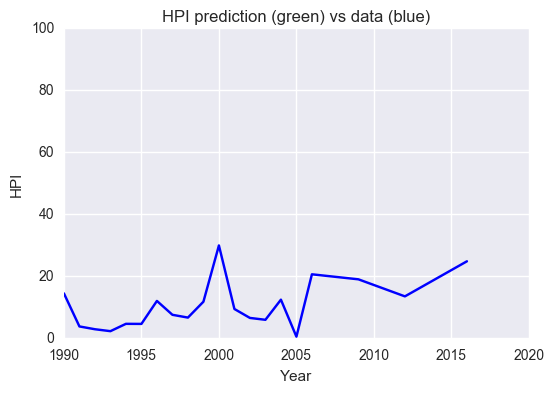

The average percantage error: 15.333161576760363 %


In [226]:
def errPercentage(value, predites):
    return (abs(value-predites)/value)*100

data_to_plot['errPercentage'] = data_to_plot.apply(lambda row: errPercentage(row['class'], row['prediction']), axis=1)

data_to_plot2 = data_to_plot.groupby('year').mean()
data_to_plot2.reset_index(inplace=True)

lines = plt.plot(data_to_plot2['year'].tolist(),data_to_plot2['errPercentage'].tolist(), color='b')

plt.ylabel('HPI')
plt.xlabel('Year')
plt.title('HPI prediction (green) vs data (blue)')
plt.ylim(0,100)
plt.show()

print('The average percantage error:', data_to_plot['errPercentage'].mean(), '%')

## HPI of test by countries

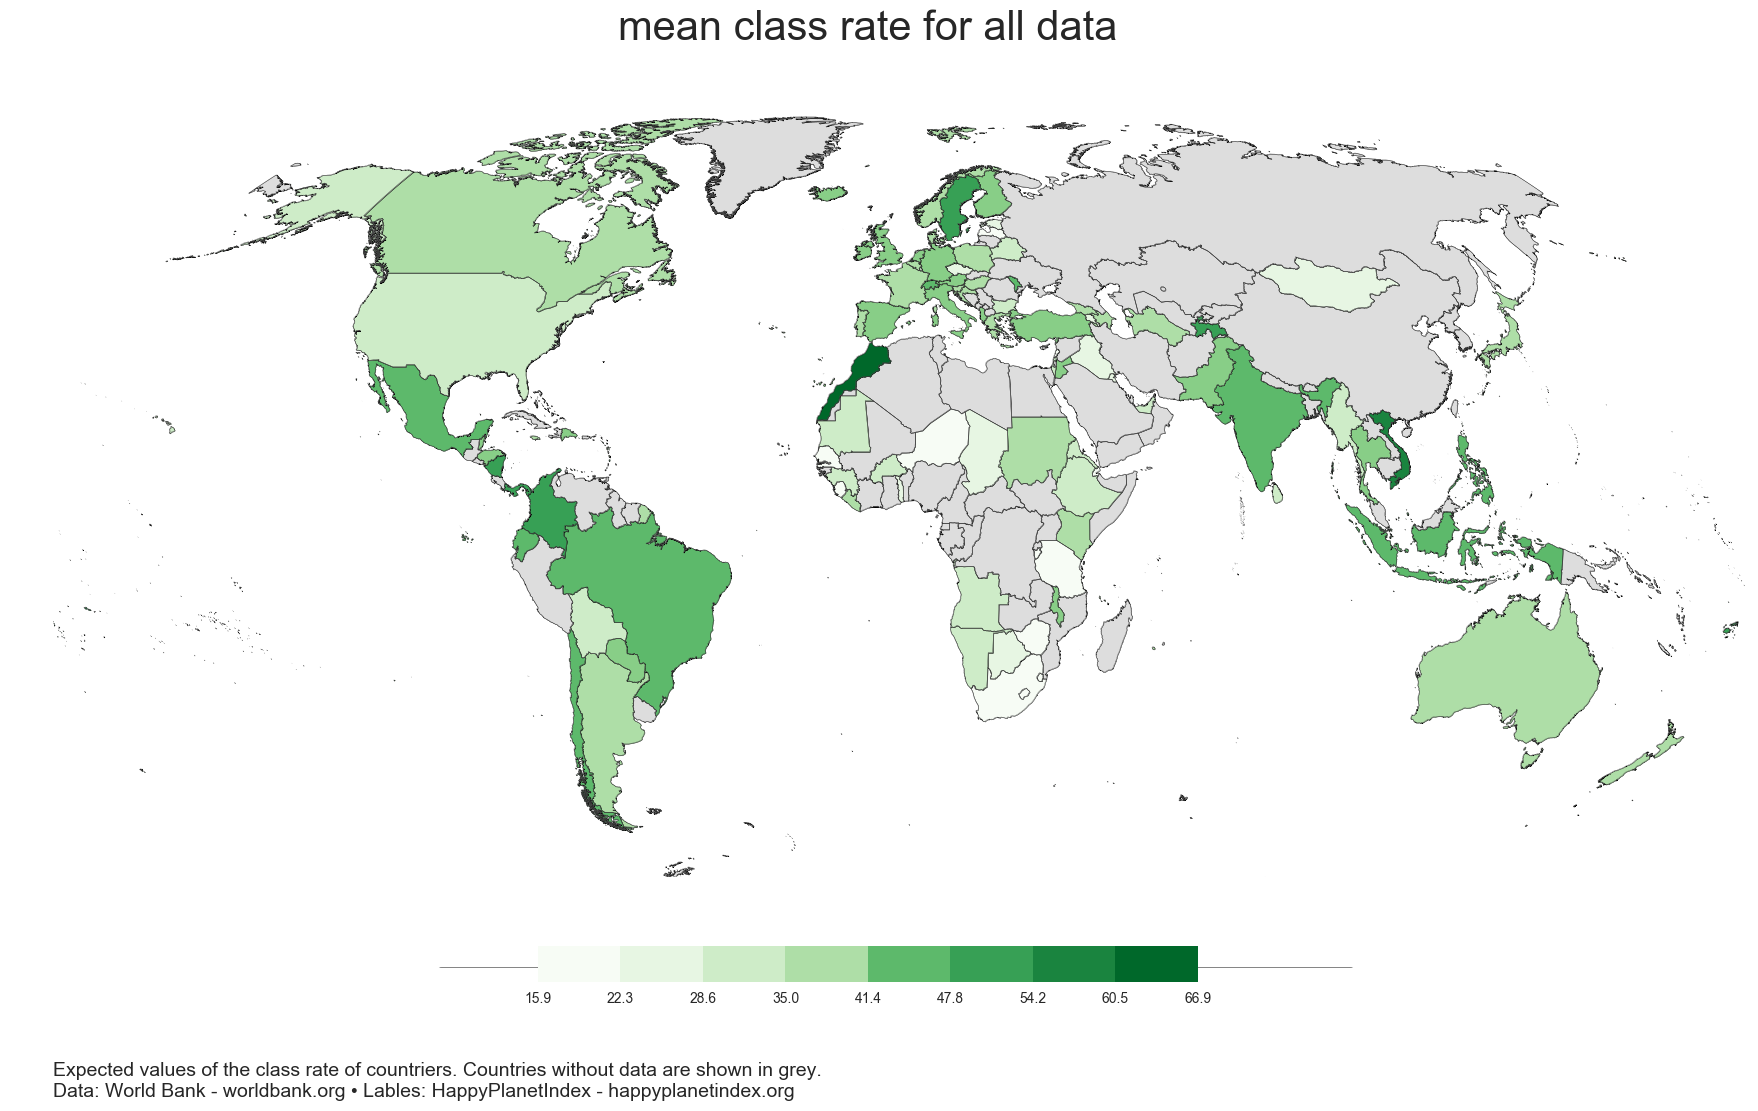

In [228]:
plotDataOnMap(data_to_plot, feature='class', year='mean')

## Predicted HPI of test by countries

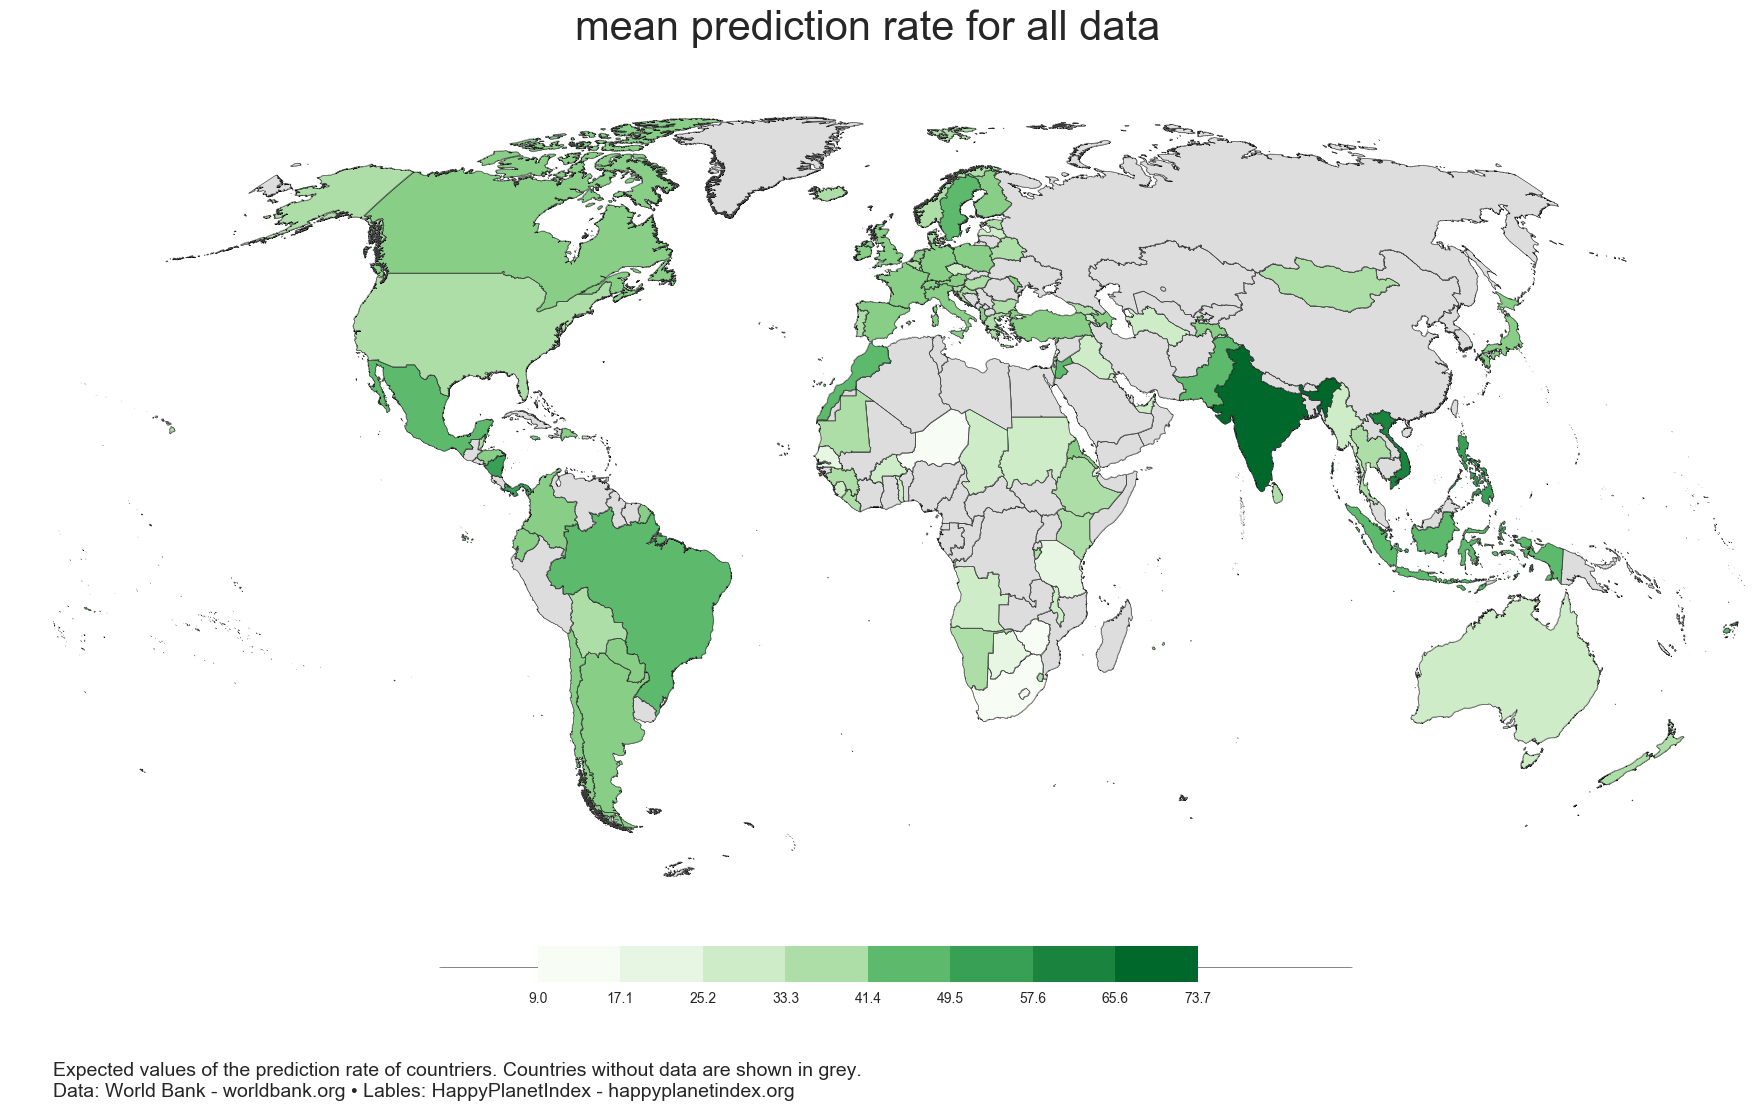

In [229]:
plotDataOnMap(data_to_plot, feature='prediction', year='mean')

## Countries that the rediction missed

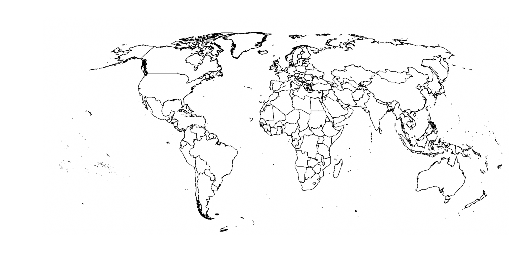

In [230]:
predicted_image = globe_plots + 'prediction_mean.png'
actual_image = globe_plots + 'class_mean.png'
output_image = uncorrolated_plots + 'prediction-class.png'
plotUncorrolatedCountries(predicted_image, actual_image, output_image)